# Table of Contents

## Introduction

- **Brief Overview**: A quick summary of the problem at hand and the objectives of the A/B test.

---

## Data Preprocessing and EDA

- **Basic Stats**: Descriptive statistics to understand the dataset.
- **Data Cleaning**: Handling missing values, outliers, etc.
- **Exploratory Analyses**: Plots and other visualizations to understand the data distribution and relationships.

---

## Metrics Definition

- **Key Metrics**: Clear definitions of the metrics (Conversion Rate, ARPU, etc.) that will be used for evaluating the A/B test.

---

## Experiment Designs for A/B Tests

- **Hypotheses**: Null and alternative hypotheses for the two-tailed test.
- **Test Parameters**: Significance level, practical significance level, etc.

---

## A/B Test Execution for A/B Tests

- **Code**: The actual Python code for executing the two-tailed Z-test.
- **Interpretation**: Discussion of the test results, including statistical and practical significance.

---

## Conclusion

- **Summary**: A wrap-up of the key findings from the A/B tests, their implications and recommendations.
- **Metrics Considered**: Other metrics considered.

---

## Appendices (Optional)

- **Additional Analyses**: One-Tailed Test 


# Introduction and Objectives

This notebook aims to perform a comprehensive A/B test analysis on the starter offers for a mobile game. The company has recently made changes to its starter offer, reducing the price fivefold and offering half the original content. The goal of this analysis is to evaluate the impact of this change on several key business metrics.

## Objectives

The key objectives of this analysis are to evaluate the change in:

1. **Conversion Rate**: The proportion of users who make a purchase after installing the game.
2. **Average Revenue Per User (ARPU)**: The average revenue generated per user.
3. **Average Revenue Per Paying User (ARPPU)**: The average revenue generated per user who makes a purchase.

## Business Context

Understanding the impact of the starter offer change is important for:
- Making informed decisions on pricing strategy.
- Identifying opportunities to optimize user engagement and revenue.

**Note**: The formulation of the null and alternative hypotheses will be detailed later in this notebook

## Experimental Design

- **Splitting Mechanism**: The dataset has already been split into Control and Test groups.
- **Randomization**: The randomization is assumed to have been done prior to data collection.
- **Comparability**: Before proceeding with the analysis, we will check if the two groups are statistically comparable based on available metrics.

## Data Collection

- **Data Collection Mechanism**: The dataset has been provided, so this step has been performed already.
- **Dataset**: `user_id`, `install_time`, `payment_time`, `amount`, `ab_group` are the available data points for both groups.

# Data Loading

In this section, we will load the dataset and take a look at its structure. This will help us understand what kind of data we are dealing with and how to approach the subsequent analysis.


In [2]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Statistical Libraries
from scipy.stats import probplot, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau,norm
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Load the dataset
df = pd.read_csv('starter_offer_ab_dataset.csv')

# Display the first few rows of the dataset
df.head()

,user_id,ab_group,install_time,payment_time,amount
0,300647965935,1,2005-05-20 03:00:27,NaN,NaN
1,300647965937,2,2005-05-20 03:00:48,NaN,NaN
2,300647965938,2,2005-05-20 03:00:50,NaN,NaN
3,300647965942,1,2005-05-20 03:02:07,NaN,NaN
4,300647965950,2,2005-05-20 03:06:02,NaN,NaN


## Data Preprocessing and Cleaning

- **Data Integrity Checks**: Confirm no duplicate or erroneous entries exist.
- **Missing Value Checks**: Check for missing values

In [3]:
# Step 7.1: Data Integrity Check 
missing_values = df[['user_id', 'ab_group']].isnull().sum()

# Confirm that 'amount' is null when 'payment_time' is null
amount_payment_time_check = df[df['amount'].isnull()]['payment_time'].isnull().all()

duplicate_values = df.duplicated().sum()

# Step 7.2: Data Type Validation -
data_types_check = df.dtypes

print("Data Preprocessing Results")
print("--------------------------")
print(f"Data Integrity Check: Missing values in 'user_id' and 'ab_group':\n{missing_values.to_string()}")
print(f"    - 'amount' is null when 'payment_time' is null: {amount_payment_time_check}")
print(f"    - Duplicate values: {duplicate_values}")
print("")
print(f"Data Type Validation: Data types of columns:\n{data_types_check}")

Data Preprocessing Results
--------------------------
Data Integrity Check: Missing values in 'user_id' and 'ab_group':
user_id     0
ab_group    0
    - 'amount' is null when 'payment_time' is null: True
    - Duplicate values: 0

Data Type Validation: Data types of columns:
user_id           int64
ab_group          int64
install_time     object
payment_time     object
amount          float64
dtype: object


In [4]:
df.groupby('user_id')['ab_group'].nunique().value_counts()

1    72813
2       40
Name: ab_group, dtype: int64

Only 40 users have both ab_group values

### Sample Size and Proportions

- **Balance**: We will evaluate whether the sample sizes for the Control and Test groups are adequately balanced.
- **Assumptions and Requirements**: Discuss if the sample sizes meet the assumptions or requirements for a valid A/B test.

In [5]:
control_group = df[df['ab_group'] == 1]
test_group = df[df['ab_group'] == 2]

# 3 The sample size
unique_users_control = control_group['user_id'].nunique()
unique_users_test = test_group['user_id'].nunique()

# Calculate the proportion of samples in each group
total_sample_size = unique_users_control + unique_users_test
proportion_control = unique_users_control / total_sample_size
proportion_test = unique_users_test / total_sample_size

In [6]:
# Print the results in a readable format
print("A/B Test Sample Size and Proportion Summary")
print("-------------------------------------------")
print(f"Total Unique Users in Dataset: {total_sample_size}")
print("")
print("Control Group:")
print(f"  - Unique Users (Sample Size): {unique_users_control}")
print(f"  - Proportion of Total: {proportion_control * 100:.2f}%")
print("")
print("Test Group:")
print(f"  - Unique Users (Sample Size): {unique_users_test}")
print(f"  - Proportion of Total: {proportion_test * 100:.2f}%")

A/B Test Sample Size and Proportion Summary
-------------------------------------------
Total Unique Users in Dataset: 72893

Control Group:
  - Unique Users (Sample Size): 36188
  - Proportion of Total: 49.65%

Test Group:
  - Unique Users (Sample Size): 36705
  - Proportion of Total: 50.35%


### Sample Size and Proportions Interpretation

- **Balance**: The proportions between the Control and Test groups are approximately equal (50% each), indicating that the sample sizes are adequately balanced for the purpose of this A/B test.
- **Assumptions and Requirements**: The almost equal division into Control and Test groups meets the requirements for a valid A/B test, ensuring that statistical power is maintained. This balance allows for more reliable results.

## Exploratory Data Analysis (EDA)

Perform initial data exploration to understand the dataset's structure, types, and missing values.
- **Data Types**: Confirm the data types are as expected for each column.
- **Summary Statistics**: Provide basic statistics to understand the data distribution.

In [7]:
df['install_time'] = pd.to_datetime(df['install_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['payment_time'] = pd.to_datetime(df['payment_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Check data types and null values
print(df.info())

# Check summary statistics
df.describe(include = 'all' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83296 entries, 0 to 83295
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       83296 non-null  int64         
 1   ab_group      83296 non-null  int64         
 2   install_time  83296 non-null  datetime64[ns]
 3   payment_time  12262 non-null  datetime64[ns]
 4   amount        12262 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 3.2 MB
None


/var/folders/tp/fgk3g2gs5bsbfwrmfy1n6lj40000gn/T/ipykernel_19487/1045526565.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all' )
/var/folders/tp/fgk3g2gs5bsbfwrmfy1n6lj40000gn/T/ipykernel_19487/1045526565.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all' )


,user_id,ab_group,install_time,payment_time,amount
count,8.329600e+04,83296.000000,83296,12262,12262.000000
unique,NaN,NaN,72198,12250,NaN
top,NaN,NaN,2005-07-10 03:33:54,2005-06-17 03:42:33,NaN
freq,NaN,NaN,96,2,NaN
first,NaN,NaN,2005-05-20 03:00:27,2005-05-20 16:37:36,NaN
last,NaN,NaN,2005-07-20 02:59:33,2005-08-18 23:38:54,NaN
mean,2.982599e+11,1.501801,NaN,NaN,1597.178927
std,9.016683e+09,0.500000,NaN,NaN,3528.642055
min,2.662880e+11,1.000000,NaN,NaN,100.000000
25%,3.006480e+11,1.000000,NaN,NaN,499.000000


In [8]:
# Descriptive Statistics for Control and Test Groups
print("Summary statistics for Control Group:")
print(df[df['ab_group'] == 1]['amount'].describe())
print()
print("Summary statistics for Test Group:")
print(df[df['ab_group'] == 2]['amount'].describe())


Summary statistics for Control Group:
count     6157.000000
mean      1803.856261
std       3916.283727
min        499.000000
25%        499.000000
50%        499.000000
75%        999.000000
max      24999.000000
Name: amount, dtype: float64

Summary statistics for Test Group:
count     6105.000000
mean      1388.741196
std       3075.104191
min        100.000000
25%        499.000000
50%        499.000000
75%        999.000000
max      24999.000000
Name: amount, dtype: float64


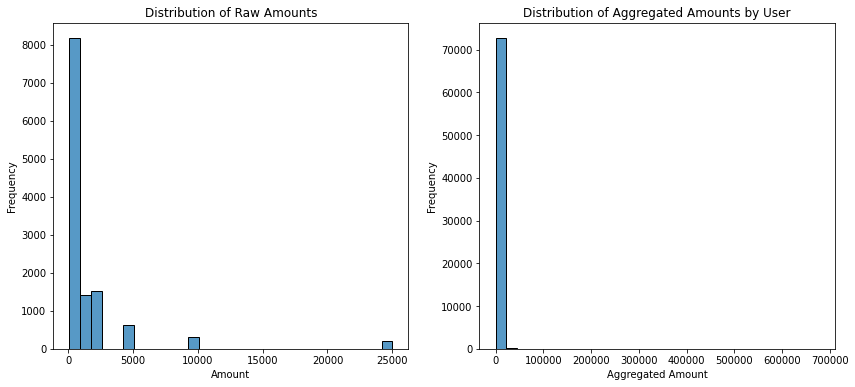

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6)) 

# Distribution of raw amounts
sns.histplot(df['amount'], bins=30, kde=False, ax=axs[0],)
axs[0].set_title('Distribution of Raw Amounts',)
axs[0].set_xlabel('Amount')
axs[0].set_ylabel('Frequency')

# Distribution of aggregated amounts by user
agg_amount_by_user = df.groupby('user_id')['amount'].sum()
sns.histplot(agg_amount_by_user, bins=30, kde=False, ax=axs[1])
plt.title('Distribution of Aggregated Amounts by User')
plt.xlabel('Aggregated Amount')
plt.ylabel('Frequency')
plt.show()


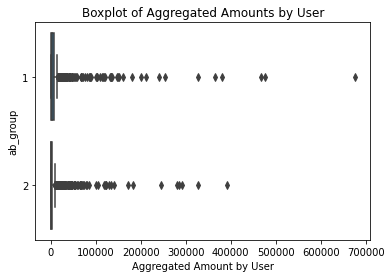

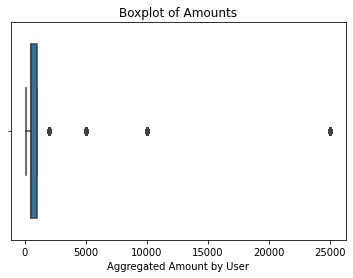

In [10]:

df_sum_group = df.groupby(['user_id', 'ab_group'])['amount'].sum().reset_index()
df_sum_group['ab_group'] = df_sum_group['ab_group'].astype('category')
df_sum_group = df_sum_group[df_sum_group['amount'] > 0]

# Boxplot of Aggregated Amounts by User
sns.boxplot( x='amount', y='ab_group', data=df_sum_group)
plt.title('Boxplot of Aggregated Amounts by User')
plt.xlabel('Aggregated Amount by User')
plt.show()

# Boxplot of Amounts
sns.boxplot(x=df['amount'],)
plt.title('Boxplot of Amounts')
plt.xlabel('Aggregated Amount by User')
plt.show()

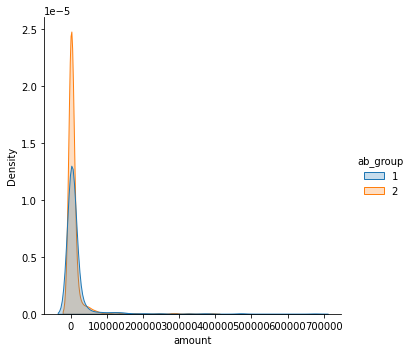

In [11]:
sns.displot(df_sum_group, x="amount", hue="ab_group", kind="kde", fill=True)

### **Outlier Handling** : Identify and make a decision on the inclusion/exclusion of outliers.

- **Methodology**: We will use Q-Q plots to check for normality and the IQR method for outlier detection.

Business Context: 
* High-value users are particularly important in a freemium mobile game context. These users could appear as outliers but are often the most valuable customers.
* High spending by a user is not necessarily erroneous or anomalous; it could be a business-critical behavior.

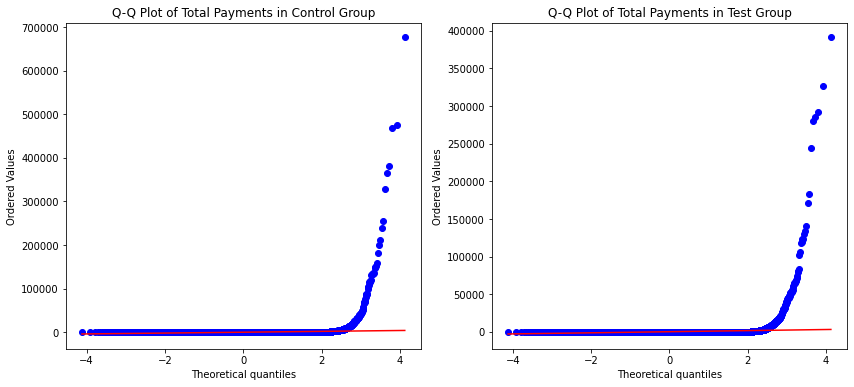

In [12]:
# Function to show Q-Q plots aligned horizontally
def show_qq_plots(control_data, test_data):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    probplot(control_data['amount'], plot=axs[0])
    axs[0].set_title('Q-Q Plot of Total Payments in Control Group')
    
    probplot(test_data['amount'], plot=axs[1])
    axs[1].set_title('Q-Q Plot of Total Payments in Test Group')
    
    plt.show()

# Prepare the data
control_data_for_qq = control_group.groupby('user_id')['amount'].sum().reset_index()
test_data_for_qq = test_group.groupby('user_id')['amount'].sum().reset_index()

# Show Q-Q plots
show_qq_plots(control_data_for_qq, test_data_for_qq)

In [13]:
# Function to identify outliers using IQR method on aggregated amounts by user
def identify_outliers(data, group_name):
    # Group by 'user_id' and sum the 'amount'
    grouped_data = data.groupby('user_id')['amount'].sum().reset_index()
    
    # Calculate Q1, Q3, and IQR
    Q1 = grouped_data['amount'].quantile(0.25)
    Q3 = grouped_data['amount'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Identify outliers
    outliers = grouped_data[(grouped_data['amount'] < (Q1 - 1.5 * IQR)) | 
                            (grouped_data['amount'] > (Q3 + 1.5 * IQR))]
    
    # Calculate the proportion of outliers
    proportion_outliers = len(outliers) / data['user_id'].nunique()
    
    print(f"{group_name} Group:")
    print(f"  - Number of outliers: {len(outliers)}")
    print(f"  - Proportion of outliers: {proportion_outliers * 100:.2f}%")
    print("")

# Identify outliers for Control and Test groups
identify_outliers(control_group, 'Control')
identify_outliers(test_group, 'Test')


Control Group:
  - Number of outliers: 853
  - Proportion of outliers: 2.36%

Test Group:
  - Number of outliers: 1014
  - Proportion of outliers: 2.76%



## Decision on Outliers

- **Inclusion/Exclusion**: Outliers will be included in the analysis.
- **Rationale**: The decision to include outliers is based on their business significance. High-paying users, although outliers, can significantly impact revenue and are therefore important to consider.
- **Sensitivity Analysis**: A sensitivity analysis can be performed later to assess the impact of including outliers on the final results of the A/B test.



#### In this section, we will calculate and explore three key metrics:

1. **Conversion Rate**: The proportion of users who make a purchase after installing the game.
2. **Average Revenue Per User (ARPU)**: The average revenue generated per user.
3. **Average Revenue Per Paying User (ARPPU)**: The average revenue generated per user who makes a purchase.


In [14]:
# Define function to calculate Conversion Rate
def calculate_conversion_rate(df):
    unique_users = df['user_id'].nunique()
    paying_users = df[df['amount'] > 0 ]['user_id'].nunique()
    return paying_users / unique_users if unique_users != 0 else 0

# Define function to calculate ARPU (Average Revenue Per User)
def calculate_arpu(df):
    unique_users = df['user_id'].nunique()
    total_revenue = df['amount'].sum()
    return total_revenue / unique_users if unique_users != 0 else 0

# Define function to calculate ARPPU (Average Revenue Per Paying User)
def calculate_arppu(df):
    # define paying user as user who has paid at least once
    paying_users = df[df['amount'] > 0 ]['user_id'].nunique()
    total_revenue = df['amount'].sum()
    return total_revenue / paying_users if paying_users != 0 else 0

def calculate_arppu2(df):
    paying_users = df[df['amount'] > 0]['user_id'].nunique()
    total_revenue = df['amount'].sum()
    return total_revenue / paying_users if paying_users != 0 else 0


# Calculate metrics for Control Group
conversion_rate_control = calculate_conversion_rate(control_group)
arpu_control = calculate_arpu(control_group)
arppu_control = calculate_arppu(control_group)

# Calculate metrics for Test Group
conversion_rate_test = calculate_conversion_rate(test_group)
arpu_test = calculate_arpu(test_group)
arppu_test = calculate_arppu(test_group)

# Compile the metrics into a DataFrame for easier comparison and visualization
metrics_df = pd.DataFrame({
    'Metric': ['Conversion Rate', 'ARPU', 'ARPPU',],
    'Control Group': [conversion_rate_control, arpu_control, arppu_control],
    'Test Group': [conversion_rate_test, arpu_test, arppu_test]
})
# calculate percentage change
# metrics_df['Percent Change'] = (metrics_df['Test Group'] - metrics_df['Control Group']) / metrics_df['Control Group'] * 100
metrics_df

,Metric,Control Group,Test Group
0,Conversion Rate,0.023571,0.027626
1,ARPU,306.906792,230.983926
2,ARPPU,13020.331770,8361.208087


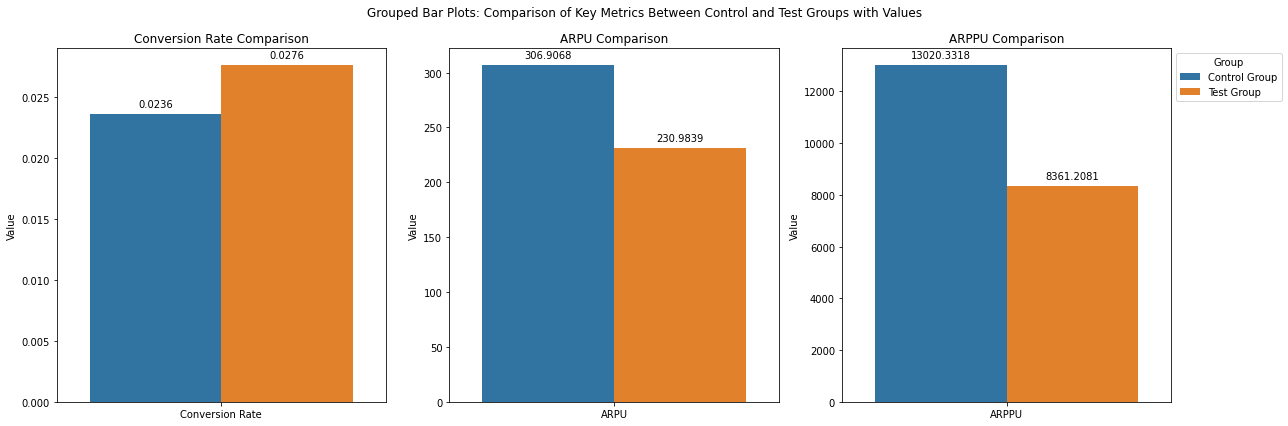

In [15]:
# Generate separate vertical grouped bar plots for each metric, all aligned horizontally, with bar values
melted_df = metrics_df.melt(id_vars='Metric', var_name='Group', value_name='Value')
metrics = ['Conversion Rate', 'ARPU', 'ARPPU']

# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the metrics for plotting
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='Metric', y='Value', hue='Group', data=melted_df[melted_df['Metric'] == metric], ax=ax)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel('Value')
    ax.set_xlabel('')
    
    # Remove the legend for all subplots
    ax.legend_.remove()
    
    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add an overall title
plt.suptitle('Grouped Bar Plots: Comparison of Key Metrics Between Control and Test Groups with Values')

# Add a single legend outside the plot
plt.legend(title='Group', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to make room for the legend
plt.show()


# Two proportion Z test: Conversion Rate

### Conversion Rate Experiment Design: Hypothesis, Test Selection, and Parameters

#### Objectives and Business Context

The primary objective of this test is to evaluate the impact of a modified starter offer on the Conversion Rate within a mobile game store. The starter offer's price for the test group has been reduced fivefold, while its content has been halved. The Conversion Rate is defined as the proportion of users who make a purchase after installing the game.

#### Note on Test Choice

The problem statement explicitly asks us to "evaluate the effect of the change for the test group." It does not specify a directional hypothesis (i.e., whether the conversion rate will increase or decrease). To comply with the problem and to keep our analysis unbiased, a two-tailed test is chosen. This allows us to detect any statistically significant change, whether positive or negative.

#### Hypotheses

- **Null Hypothesis (\(H_0\))**: The modified starter offer will not result in a statistically significant change in the Conversion Rate.
- **Alternative Hypothesis (\(H_a\))**: The modified starter offer will result in a statistically significant change in the Conversion Rate.

#### Choice of Two-Tailed Z-Test for Proportions

##### Rationale:

1. **Alignment with Problem Statement**: The problem statement asks for an evaluation of the effect without specifying a direction. A two-tailed test is more aligned with this requirement, as it allows for the detection of any change, whether an increase or decrease.
  
2. **Statistical Robustness**: A Proportion Z-test is appropriate due to the large enough sample sizes in both the control and test groups, validating its statistical robustness.
  
3. **Central Limit Theorem**: Given the large sample size, the sampling distribution of the sample proportion is expected to approximate a normal distribution, justifying the use of a Proportion Z-test.

4. **Ease of Interpretation**: Z-tests are straightforward to understand and interpret, making them suitable for this business context.

#### Test Parameters

- **Significance Level (\(\alpha\))**: 0.05
- **Practical Significance Level**: Dependens on the business context.
- **Test Power**: Can be calculated post-hoc based on the observed effect size and sample size.

#### Checking Assumptions

Before executing the statistical tests for conversion rate, let's confirm that our dataset meets the essential assumptions for a Z-test for proportions:

1. **Independence**: Each observation should be independent of others. This is usually built into the study design.
2. **Sample Size**: We have sufficiently large sample sizes for both the Control and Test groups.
3. **Binomial Distribution**: The metric under test (Conversion Rate) follows a binomial distribution.
4. **Normal Distribution**: Can the binomial distribution be approximated to a Normal distribution? - Yes, the np and n(1-p) values for both samples are >= 10
5. **Random Sampling**


In [16]:
# Checking if np and n(1-p) values for both samples are >= 10
THRESHOLD = 10 

# Extract conversion rates directly from metrics_df
def get_conversion_rate(metrics_df, group_column_name):
    return metrics_df.loc[metrics_df['Metric'] == 'Conversion Rate', group_column_name].values[0]

p_control = get_conversion_rate(metrics_df, 'Control Group')
p_test = get_conversion_rate(metrics_df, 'Test Group')

# Calculate expected number of successes and failures
def calculate_success_failure(num_users, conversion_rate):
    successes = num_users * conversion_rate
    failures = num_users * (1 - conversion_rate)
    return successes, failures

successes_control, failures_control = calculate_success_failure(unique_users_control, p_control)
successes_test, failures_test = calculate_success_failure(unique_users_test, p_test)

# Check assumptions
def check_assumptions(successes, failures, threshold):
    return successes > threshold and failures > threshold

if check_assumptions(successes_control, failures_control, THRESHOLD) and check_assumptions(successes_test, failures_test, THRESHOLD):
    print("Assumption checks passed for both groups.")
else:
    print("Assumption checks failed.")
    if not check_assumptions(successes_control, failures_control, THRESHOLD):
        print("Issue with the Control Group.")
    if not check_assumptions(successes_test, failures_test, THRESHOLD):
        print("Issue with the Test Group.")

Assumption checks passed for both groups.


In [17]:
# Z-test for comparing two proportions

count_success_test = test_group[test_group['amount'] > 0]['user_id'].nunique()
count_success_control = control_group[control_group['amount'] > 0]['user_id'].nunique()

# Number of observations (unique users)
nobs_test = test_group['user_id'].nunique()
nobs_control = control_group['user_id'].nunique()

# Perform the Z-test
z_stat, p_value = proportions_ztest([count_success_test, count_success_control], [nobs_test, nobs_control], alternative='two-sided')

# Calculate the 95% Confidence Interval
confidence_interval_test = proportion_confint(count_success_test, nobs_test, alpha=0.05, method='normal')
confidence_interval_control = proportion_confint(count_success_control, nobs_control, alpha=0.05, method='normal')

print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {p_value:.5f}")
print(f"Confidence Interval (Test Group): {confidence_interval_test}")
print(f"Confidence Interval (Control Group): {confidence_interval_control}")

# Check for statistical significance
alpha = 0.05
if p_value < alpha:
    print("Result: The test is statistically significant.")
else:
    print("Result: The test is not statistically significant.")


Z-statistic: 3.46
P-value: 0.00053
Confidence Interval (Test Group): (0.025948951647883314, 0.029302376509043535)
Confidence Interval (Control Group): (0.02200828014337147, 0.02513441909394477)
Result: The test is statistically significant.


### A/B Test Results and Conclusion: Conversion rate

### Statistical Test Outcome

- **Z-statistic**: 3.46
- **P-value**: 0.00053

The p-value is significantly less than our alpha level of 0.05. Thus, we can reject the null hypothesis. The results indicate that the observed difference in conversion rates between the test and control groups is statistically significant. 

#### Confidence Intervals

- **95% Confidence Interval for Test Group**: [0.0259, 0.0293]
- **95% Confidence Interval for Control Group**: [0.0220, 0.0251]

The 95% confidence intervals for the conversion rates of the test and control groups are [0.0259, 0.0293] and [0.0220, 0.0251], respectively. These intervals do not overlap, which provides evidence to support the claim that the conversion rate for the test group is genuinely higher than that for the control group.

### Interpretation

The Z-statistic of 3.46 and the p-value of 0.00053 strongly suggest that the conversion rate for the test group is higher than for the control group. This is also supported by the non-overlapping confidence intervals. 

### Practical Significance

Given the observed difference in conversion rates and the fact that the test is statistically significant, it would be possible to consider implementing the changes made in the test group to the larger audience if the results are above the threshold of practical significance. However it is crucial to consider important business metrics, such as revenue metrics, to ensure that the increase in conversion rate also translates into a positive impact on revenue. This will be done in the next section.

## Two Sample test: ARPU and ARPPU

### ARPU Experiment Design: Hypothesis, Test Selection, and Parameters

#### Objectives and Business Context

Aim is to evaluate if the changes implemented in the test group lead to a statistically significant difference in the ARPU compared to the control group. The starter offer in the test group has a fivefold lower price and half as much content. The business context involves understanding how this pricing strategy impacts the revenue generated per user.

## 2. Metrics Definition

**ARPU (Average Revenue Per User)**: It's the total revenue generated by the group divided by the total number of users in that group.

$$
\text{ARPU} = \frac{\text{Total Revenue of Group}}{\text{Total Users in Group}}
$$

**ARPU (Average Revenue Per Paying User)**:  It's the total revenue generated by the group divided by the number of paying users in that group.

$$
\text{ARPPU} = \frac{\text{Total Revenue of  Group}}{\text{Total Paying Users in Group}}
$$

#### Hypotheses 1

- **Null Hypothesis (\(H_0\))**: The modified starter offer has no impact on the ARPU.
- **Alternative Hypothesis (\(H_a\))**: The modified starter offer results in a statistically significant change (either increase or decrease) in ARPU.

#### Hypotheses 1

- **Null Hypothesis (\(H_0\))**: The modified starter offer has no impact on the ARPPU.
- **Alternative Hypothesis (\(H_a\))**: The modified starter offer results in a statistically significant change (either increase or decrease) in ARPPU.

#### Test Parameters

- **Significance Level (\(\alpha\))**: 0.05
- **Practical Significance Level**: To be determined based on business context and observed data.


#### Checking Assumptions

Before executing the statistical tests for Average Revenue metrics, let's confirm that our dataset meets the essential assumptions for a T-test for proportions:

1. **Independence**: The observations in the control group and the test group are independent of each other.Built into the study design.
2. **Equality of Variances**: The variances of the dependent variable should be equal in both groups: Levene's Test verifies this.
3. **Sample Size**: There should be no extreme imbalance in sample sizes between groups. Sample sizes are roughly equal. 
4. **Normal Distribution of Sample Mean**: Considering our large sample size and the nature of our metrics, it might be reasonable to proceed with the t-tests for comparing means if the Levene's test for equal variances passes.

In [18]:
# Checking for equality of variances

# Calculate Revenue per user (RPU)
rpu_control = control_group.groupby('user_id')['amount'].sum().reset_index()
rpu_test = test_group.groupby('user_id')['amount'].sum().reset_index()

stat, p_value = levene(rpu_control['amount'], rpu_test['amount'])

print(f"Levene's Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Variances are significantly different between the two groups.")
else:
    print("Variances are not significantly different between the two groups.")

Levene's Test Statistic: 2.654566330336067
P-value: 0.10325723434289037
Variances are not significantly different between the two groups.


In [19]:
# ARPPU (average revenue for users who have made a payment)
rppu_control = control_group[control_group['amount'].notna()].groupby('user_id')['amount'].sum().reset_index()
rppu_test = test_group[test_group['amount'].notna()].groupby('user_id')['amount'].sum().reset_index()

# Check levenes test for these as well

stat, p_value = levene(rppu_control['amount'], rppu_test['amount'])

print(f"Levene's Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Variances are significantly different between the two groups.")
else:
    print("Variances are not significantly different between the two groups.")

Levene's Test Statistic: 5.516291444599683
P-value: 0.01894404608850161
Variances are significantly different between the two groups.


* For ARPU, the variances between the groups are approximately equal, which makes the t test more robust.
* For ARPPU, the variances are not equal. 
* Decision is to execute Mann-Whitney U test because it is generally considered robust against this violation as well.

In [20]:
def mann_whitney_test_with_ci(control, test, variable, alpha=0.05):
    # Perform the test
    u_statistic, p_value = mannwhitneyu(control['amount'], test['amount'], alternative='two-sided')
    
    # Calculate the confidence interval
    n1 = len(control)
    n2 = len(test)
    mean_u = n1 * n2 / 2
    std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (u_statistic - mean_u) / std_u
    z_critical = norm.ppf(1 - alpha/2)
    ci_lower = mean_u + (z - z_critical) * std_u
    ci_upper = mean_u + (z + z_critical) * std_u
    
    # Interpret the results
    if p_value < alpha:
        return f"The p-value for the Mann-Whitney U test is {p_value}. We reject the null hypothesis, suggesting a significant difference in {variable} between the Control and Test groups.\n Confidence Interval: ({ci_lower}, {ci_upper})"
    else:
        return f"The p-value for the Mann-Whitney U test is {p_value}. We fail to reject the null hypothesis, suggesting no significant difference in {variable} between the Control and Test groups.\n Confidence Interval: ({ci_lower}, {ci_upper})"

# Mann-Whitney U Test for ARPU
result_arpu = mann_whitney_test_with_ci(rpu_control, rpu_test, 'ARPU')

# Mann-Whitney U Test for ARPPU
result_arppu = mann_whitney_test_with_ci(rppu_control, rppu_test, 'ARPPU')

print(result_arpu)
print(result_arppu)


The p-value for the Mann-Whitney U test is 0.0008517742523960054. We reject the null hypothesis, suggesting a significant difference in ARPU between the Control and Test groups.
 Confidence Interval: (655980225.8395438, 667114919.1604562)
The p-value for the Mann-Whitney U test is 5.1299171143513464e-18. We reject the null hypothesis, suggesting a significant difference in ARPPU between the Control and Test groups.
 Confidence Interval: (509664.4374929599, 555149.5625070401)


### A/B Test Results and Conclusion: ARPU and ARPPU

---

#### Statistical Test Outcome



- **P-value for ARPU**: 0.00085
- **P-value for ARPPU**: 5.13e-18

Given that both p-values are significantly below our alpha level of 0.05, we reject the null hypothesis for both ARPU and ARPPU. This indicates that there are statistically significant differences in these metrics between the Control and Test groups. Given that the test group was offered a fivefold lower price and half as much content for the starter offer, these significant differences are crucial.

---

#### Interpretation

##### ARPU

The Test group shows a lower ARPU compared to the Control group. The p-value of 0.00085 strongly supports rejecting the null hypothesis, confirming a statistically significant difference. This suggests that while more users might be purchasing the starter offer due to its lower price, this has not been sufficient to offset the lower price point, thereby affecting the overall revenue per user negatively.


##### ARPPU

Similarly, the Test group shows a significantly lower ARPPU compared to the Control group. With a p-value close to zero (5.13e-18), we reject the null hypothesis, confirming a statistically significant difference. This indicates that among paying users, the Test group generated less revenue per user.


---

#### Practical Significance

This information should be critically assessed alongside business goals and other non-quantifiable metrics for a comprehensive decision. The statistically significant decreases in both ARPU and ARPPU for the Test group suggest that the strategy of lowering the price point may have backfired in terms of overall revenue metrics. Careful consideration should be given before scaling these changes to the larger audience. This information should be critically assessed alongside business goals and other non-quantifiable metrics to make a comprehensive decision.

## Recommendations

1. **Conversion Rate**: Given the increase in conversion rate, further tests could be conducted to assess the long-term impact on retention and lifetime value.
  
2. **ARPU and ARPPU**: The decrease in both ARPU and ARPPU suggests that while the test group strategy may have increased the number of purchasers, it has likely done so at the cost of overall revenue. Reconsider the pricing strategy and perhaps test a middle-ground price point.

3. **Comprehensive Assessment**: Before rolling out changes, consider the combined effect of all metrics. An increased conversion rate is positive but should not come at the expense of significantly decreased revenue per user or per paying user.

## Next Steps

1. **Longitudinal Study**: Assess the long-term impact of the changes on metrics like customer retention and lifetime value.

2. **Financial Modeling**: Conduct a financial analysis to quantify the potential revenue impact of implementing the changes.


## Additional Metrics to Consider

Given the nature of the A/B test and the mobile gaming context, the following metrics could offer further insights:

### 1. Customer Retention Rate:

Understanding how the new starter offer impacts customer retention could be valuable. If the new offer attracts more customers but fails to retain them, it might not be sustainable in the long run.

### 2. Customer Lifetime Value (CLV):

CLV would give us an idea of the long-term value of a customer and whether the new starter offer positively or negatively affects this value.

### 3. Time to First Purchase:

This metric would help us understand how quickly users make their first purchase after installing the game. A decrease in this metric indicates the new offer is more enticing.

### 4. Repeat Purchase Rate:

It would be useful to know if the change in starter offer has any effect on the likelihood of a customer making subsequent purchases.

### 5. Churn Rate:

Understanding if the new starter offer causes an increase in the number of users abandoning the service can offer another angle on its efficacy.

### 6. Average Session Duration:

Understanding user engagement can be as important as understanding their spending. Longer session durations can indicate higher engagement levels, which could eventually lead to higher revenue.

### 7. User Satisfaction Rates (e.g., Net Promoter Score):

Satisfaction metrics could help gauge whether the new pricing model has an impact


# supplementary analysis

### Addidional test for conversion rate

Given that the original problem statement explicitly asks to "evaluate the effect of the change for the test group" without specifying a direction of interest, a two-tailed test was originaly chosen to strictly comply with these instructions. Two tailed approach allows us to assess any statistically significant change in the Conversion Rate, whether it be an increase or a decrease.

However, considering the nature of the modification—a fivefold decrease in price for the starter offer—it is reasonable to hypothesize that the business aim could be an increase in Conversion Rate. An increase in this rate would lead to a larger customer base, aligning with key business objectives. For the sake of completeness in the next section I also include a one-tailed test, focused specifically on detecting any significant increase in Conversion Rate. This inclusion serves to align our approach with potential business objectives, providing an understanding of the test's practical impact. Thus for this test it is **assumed** that we are uninterested in the possibility of Group A scoring lower than Group B.

### Conversion Rate Experiment Design: Hypothesis, Test Selection, and Parameters

#### Objectives and Business Context

The primary objective of this A/B test is to assess the impact of a modified starter offer on the Conversion Rate in the mobile game store. The starter offer's price in the test group has been reduced fivefold, and its content has been halved.

#### Hypotheses

- **Null Hypothesis (\(H_0\))**: The modified starter offer will not result in a statistically significant increase in the Conversion Rate.
- **Alternative Hypothesis (\(H_a\))**: The modified starter offer will result in a statistically significant increase in the Conversion Rate.

#### Choice of Z-Test

The Z-Test for proportions is our selected statistical test, for several reasons:

1. **Large Sample Size**: Both the control and test groups have a large number of users, making the Z-test statistically reliable.
2. **Central Limit Theorem**: The large sample size ensures that the sampling distribution of the sample proportion approximates a normal distribution.
3. **Ease of Interpretation**: Z-tests are straightforward to understand and interpret
4. **Suitability for Conversion Rate**: Z-tests for proportions are good fit for comparing Conversion Rates between two groups, especially when the sample sizes are large.


#### One-Tailed vs. Two-Tailed Test

We opt for a one-tailed test for the following reasons:

1. **Practical Business Context**: When implementing a change, the primary concern is often to ascertain whether the new strategy improves upon the existing one. In this context, a one-tailed test provides a more focused approach to hypothesis testing.
2. **Directional Hypothesis**: Our business aim is directional; we are specifically interested in an increase in the Conversion Rate. A one-tailed test is more appropriate for assessing directional effects.
3. **Statistical Power**: One-tailed tests are generally more powerful for detecting an effect in a specific direction.


#### Test Parameters

- **Significance Level (\(\alpha\))**: 0.05


In [21]:
# Perform the Z-test
z_stat, p_value = proportions_ztest([count_success_test, count_success_control], [nobs_test, nobs_control], alternative='larger')

# Calculate the 95% Confidence Interval
conf_interval = proportion_confint(count=[count_success_test, count_success_control], nobs=[nobs_test, nobs_control], alpha=0.05, method='normal')

# Display the results
z_stat, p_value, conf_interval
print(f"Z-statistic: {z_stat:.6f}")
print(f"P-value: {p_value:.6f}")
print(f"Confidence Interval: {conf_interval}")


Z-statistic: 3.464371
P-value: 0.000266
Confidence Interval: (array([0.02594895, 0.02200828]), array([0.02930238, 0.02513442]))



## One Tailed Test Results and Conclusion

### Statistical Test Outcome

- **Z-statistic**: 3.46
- **P-value**: 0.00027

The p-value is less than our alpha level of 0.05, indicating that the observed difference in conversion rates between the test and control groups is statistically significant. This suggests that the change in the starter offer had a significant positive impact on the conversion rate.

#### Confidence Intervals

- **95% Confidence Interval for Test Group**: [0.0259, 0.0293]
- **95% Confidence Interval for Control Group**: [0.0220, 0.0251]

The 95% confidence intervals for the conversion rates of the test and control groups are [0.0259, 0.0293] and [0.0220, 0.0251], respectively. These intervals do not overlap, providing further evidence that the test group's conversion rate is  higher than the control group's.

### Practical Significance

In the context of the experiment, we did not have prior information to set a practical significance level. However, observing the confidence intervals and the Z-statistic, we can infer that the test group shows a promising increase in conversion rate. 

It's crucial to note that in a real-world scenario, the practical significance level would typically be set by considering the business context, cost of implementing the change, and the expected benefit. 